In [1]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
import import_ipynb
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

In [2]:
from qp import get_stocks # 1/PBR + GP/A
#from ncav import get_stocks # NCAV
#from super_value import get_stocks
#from super_quality import get_stocks

importing Jupyter notebook from qp.ipynb
importing Jupyter notebook from common.ipynb


In [3]:
MODEL_NAME = 'qp'
DATA_DIR = 'data/daily/8-1'

In [4]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [5]:
df_account

,start_date,end_date,filepath
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv


In [6]:
df_price = marcap_data(df_account.iloc[0].start_date, df_account.iloc[len(df_account) - 1].end_date)

In [7]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.filepath, x.start_date), axis=1)

------------------------------
2002-08-01 data/daily/8-1/2002-08-01.csv
전체 1576
지주사, 금융사 제외 1477


common.ipynb:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "\n",


국외주식 제외 1477
유동비율 > 1 972
가격정보 없는 기업 제외 686
선정 기업 수 30
------------------------------
2003-08-01 data/daily/8-1/2003-08-01.csv
전체 1668
지주사, 금융사 제외 1569
국외주식 제외 1569
유동비율 > 1 1002
가격정보 없는 기업 제외 719
선정 기업 수 30
------------------------------
2004-08-02 data/daily/8-1/2004-08-02.csv
전체 1716
지주사, 금융사 제외 1614
국외주식 제외 1614
유동비율 > 1 1034
가격정보 없는 기업 제외 755
선정 기업 수 30
------------------------------
2005-08-01 data/daily/8-1/2005-08-01.csv
전체 1812
지주사, 금융사 제외 1708
국외주식 제외 1707
유동비율 > 1 1123
가격정보 없는 기업 제외 800
선정 기업 수 30
------------------------------
2006-08-01 data/daily/8-1/2006-08-01.csv
전체 1861
지주사, 금융사 제외 1754
국외주식 제외 1752
유동비율 > 1 1207
가격정보 없는 기업 제외 883
선정 기업 수 30
------------------------------
2007-08-01 data/daily/8-1/2007-08-01.csv
전체 1952
지주사, 금융사 제외 1841
국외주식 제외 1835
유동비율 > 1 1261
가격정보 없는 기업 제외 940
선정 기업 수 30
------------------------------
2008-08-01 data/daily/8-1/2008-08-01.csv
전체 2046
지주사, 금융사 제외 1930
국외주식 제외 1920
유동비율 > 1 1279
가격정보 없는 기업 제외 980
선정 기업 수 30
---------------------------

In [62]:
i = 0
start_date = df_account.iloc[i].start_date
end_date = df_account.iloc[i].end_date
stocks = df_account.iloc[i].stocks

In [63]:
df_yearly_price = df_price[(df_price.index >= start_date) & (df_price.index <= end_date)]

In [109]:
df_yield = pd.DataFrame()

for stock in stocks:
     
    df_yearly_stock_price = df_yearly_price[df_yearly_price.Code == stock].reset_index()
    df_yearly_stock_price['year_month'] = df_yearly_stock_price.apply(lambda x: str(x.Date)[:7], axis=1)
    df_yearly_stock_price = df_yearly_stock_price[:-1]
    
    df_monthly_yield = df_yearly_stock_price.groupby("year_month").agg({'Open': 'first', 'Close': 'last'}).reset_index()
    df_monthly_yield['yield'] = df_monthly_yield['Close'] / df_monthly_yield['Open']
    
    df_yield[stock] = df_monthly_yield['yield'].cumprod().tolist()
    
    yearly_yield = df_monthly_yield.iloc[len(df_monthly_yield)-1]['Close'] / df_monthly_yield.iloc[0]['Open']
    print(yearly_yield)
    print(df_monthly_yield['yield'].cumprod().tolist())
    break

4.849570200573066
[1.004297994269341, 0.9927210721451989, 0.8595864677175629, 0.9010123215834694, 0.9098747378613398, 0.968957513047141, 0.9482785417321105, 0.9160838998831807, 0.9656807989214422, 0.9280380691284025, 0.9799159736138411, 4.8779640745336055]


In [103]:
df_monthly_yield

,year_month,Open,Close,yield
0,2018-08,6980.0,7010.0,1.004298
1,2018-09,6940.0,6860.0,0.988473
2,2018-10,6860.0,5940.0,0.865889
3,2018-11,5810.0,6090.0,1.048193
4,2018-12,6100.0,6160.0,1.009836
5,2019-01,6160.0,6560.0,1.064935
6,2019-02,6560.0,6420.0,0.978659
7,2019-03,6480.0,6260.0,0.966049
8,2019-04,6280.0,6620.0,1.054140
9,2019-05,6670.0,6410.0,0.961019


In [65]:
df_yield['total'] = df_yield.mean(axis=1) 

In [112]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yield'] = df_account['yield'].astype('object')
df_account['yearly_yield'] = 0.0

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_yearly_price = df_price[(df_price.index >= start_date) & (df_price.index <= end_date)]
        stocks = df_account.iloc[i].stocks
        df_yield = pd.DataFrame()
        
        stock_yields = []
        for stock in stocks:
            df_yearly_stock_price = df_yearly_price[df_yearly_price.Code == stock].reset_index()
            if len(df_yearly_stock_price) == 0:
                df_yield[stock] = [0] * 12
                stock_yields.append(0)
                continue
            
            df_yearly_stock_price['year_month'] = df_yearly_stock_price.apply(lambda x: str(x.Date)[:7], axis=1)
            df_yearly_stock_price = df_yearly_stock_price[:-1]

            df_monthly_yield = df_yearly_stock_price.groupby("year_month").agg({'Open': 'first', 'Close': 'last'}).reset_index()
            df_monthly_yield['yield'] = df_monthly_yield['Close'] / df_monthly_yield['Open']
            
            monthly_yield = df_monthly_yield['yield'].cumprod().tolist()
            
            if len(monthly_yield) < 12:
                monthly_yield.extend([0] * (12 - len(monthly_yield)))
            
            df_yield[stock] = monthly_yield
            
            stock_yields.append(df_monthly_yield.iloc[len(df_monthly_yield)-1]['Close'] / df_monthly_yield.iloc[0]['Open'])
            
        df_yield['total'] = df_yield.mean(axis=1) 
        
        df_account.at[i, 'yield'] = df_yield['total'].tolist()
        
        yearly_yield = statistics.mean(stock_yields)
        df_account.at[i, 'yearly_yield'] = yearly_yield
        
        print(start_date, end_date, yearly_yield)

2002-08-01 2003-08-01 0.8362562590641034
2003-08-01 2004-08-02 0.9502175115044957
2004-08-02 2005-08-01 3.2423365780215496
2005-08-01 2006-08-01 1.2096558222758906
2006-08-01 2007-08-01 2.218813350078988
2007-08-01 2008-08-01 0.8352829847215036
2008-08-01 2009-08-03 1.2295673367369278
2009-08-03 2010-08-02 1.350235124521484
2010-08-02 2011-08-01 2.2857442932068777
2011-08-01 2012-08-01 1.5052632291465113
2012-08-01 2013-08-01 1.1751164993137673
2013-08-01 2014-08-01 1.2659357220498293
2014-08-01 2015-08-03 2.0336438351487582
2015-08-03 2016-08-01 1.525111816546971
2016-08-01 2017-08-01 1.1703647901259744
2017-08-01 2018-08-01 1.855774074588479
2018-08-01 2019-08-01 1.5095349431211678


In [114]:
df_account['total'] = df_account['yearly_yield'].cumprod()

In [115]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [116]:
df_account

,start_date,end_date,filepath,stocks,yield,yearly_yield,total,cagr
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv,"[010600, 025880, 014570, 027040, 005610, 00737...","[1.0783607055003581, 0.9938389029469836, 1.055...",0.836256,0.836256,0.836256
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv,"[010600, 014100, 025880, 004540, 008290, 03286...","[0.971539083620626, 0.93345242224973, 0.958951...",0.950218,0.794625,0.891418
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv,"[010600, 017680, 032860, 016920, 025880, 01410...","[1.0653508902093078, 1.0838495216979322, 1.056...",3.242337,2.576443,1.370903
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv,"[010600, 017680, 046310, 045060, 016920, 07965...","[0.9400074123853308, 1.1401572824055841, 1.357...",1.209656,3.116609,1.328681
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv,"[068290, 025880, 000440, 016920, 045060, 00811...","[1.108502271982615, 1.1326737070849104, 1.1857...",2.218813,6.915174,1.472179
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv,"[017680, 010600, 045060, 045660, 025880, 02495...","[0.9561084638241318, 0.9796157999491996, 0.919...",0.835283,5.776127,1.339490
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv,"[011080, 078520, 014570, 046310, 079650, 00536...","[0.9015214379032244, 0.8388364971620015, 0.577...",1.229567,7.102137,1.323205
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv,"[011080, 017680, 010470, 033340, 079650, 00798...","[1.0478171755642431, 0.9911083589721531, 1.015...",1.350235,9.589555,1.326554
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv,"[011080, 033340, 032860, 088790, 011090, 01279...","[0.9916267878651647, 1.0405307876980356, 1.080...",2.285744,21.919270,1.409226
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv,"[011080, 038320, 033340, 044380, 091440, 04631...","[1.068208295019999, 0.8831645919050077, 1.0393...",1.505263,32.994272,1.418547


In [117]:
monthly_yields = []
for i in range(len(df_account)):
    monthly_yields.extend(df_account.iloc[i]['yield'])

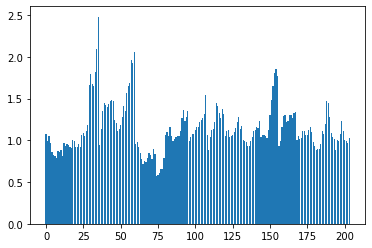

In [118]:
fig, ax = plt.subplots()
plt.bar(np.arange(len(monthly_yields)), monthly_yields)
plt.show()

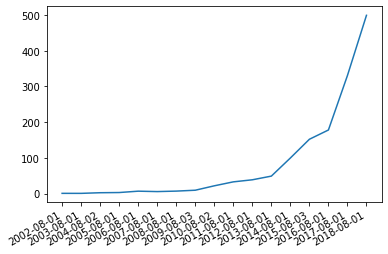

In [119]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

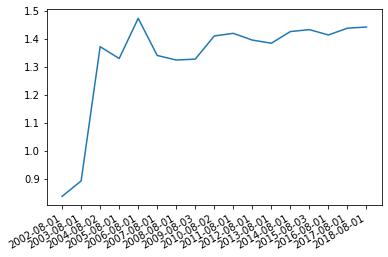

In [120]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()